# Visualize Distribution of Views for STL10 dataset

For a self-supervised learning system, it's augmentation / data generation pipeline is crucial.


In [1]:
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image

## Prepare STL10 Dataset and Pre-computed Saliency Maps

In [2]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from os.path import join
import matplotlib.pylab as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils

In [4]:
# it took 2-5 mins to download the STL10 dataset
dataset_dir = "/content/Dataset"
dataset = datasets.STL10("Dataset", split="unlabeled", download=True, transform=transforms.ToTensor(),)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting Dataset/stl10_binary.tar.gz to Dataset


In [5]:
# download the saliency data hosted at my Google Drive.
%cd /content/Dataset

# !gdown https://drive.google.com/uc?id=1tpBwMG1FsmSloqPDSQ6tfRVTeZ3RR89n # TODO: need access / source
!gdown https://drive.google.com/uc?id=1cXp7Qg0O23lGyYnjS1a7oUCOY8hw3ckn # # ran generate_salmaps_dataset.py to get stl10_unlabeled_salmaps_salicon.npy to folder /content/Dataset

/content/Dataset
Downloading...
From: https://drive.google.com/uc?id=1cXp7Qg0O23lGyYnjS1a7oUCOY8hw3ckn
To: /content/Dataset/stl10_unlabeled_salmaps_salicon.npy
100% 3.69G/3.69G [00:19<00:00, 185MB/s]


In [6]:
%cd /content/
!git clone https://github.com/Animadversio/FastSal

/content
Cloning into 'FastSal'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 154 (delta 49), reused 149 (delta 45), pack-reused 0
Receiving objects: 100% (154/154), 152.05 MiB | 20.20 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [7]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 517 kB 6.9 MB/s 


In [8]:
%cd /content/
!git clone https://github.com/Animadversio/Foveated_Saccade_SimCLR.git
%cd Foveated_Saccade_SimCLR/
!git checkout dev
!git pull

/content
Cloning into 'Foveated_Saccade_SimCLR'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 152 (delta 0), reused 2 (delta 0), pack-reused 147
Receiving objects: 100% (152/152), 1.55 MiB | 3.51 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/Foveated_Saccade_SimCLR
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
Already up to date.


## Visualize augmented dataset

In [9]:
%cd /content/Foveated_Saccade_SimCLR

/content/Foveated_Saccade_SimCLR


In [10]:
dataset_dir = "/content/Dataset"

In [11]:
from data_aug.dataset_w_salmap import Contrastive_STL10_w_salmap
from torchvision.transforms import RandomResizedCrop
from data_aug.saliency_random_cropper import RandomResizedCrop_with_Density, RandomCrop_with_Density
from data_aug.visualize_aug_dataset import visualize_samples, visualize_augmented_dataset, visualize_saliency_maps_w_imgs
from data_aug.dataset_w_salmap import Contrastive_STL10_w_CortMagnif, get_RandomMagnifTfm

In [12]:
idxs = [96659, 54019, 88327, 81148, 98469, 77493, 131, 58202, 66666, 65017]

### Control

In [13]:
# # run generate_salmaps_dataset.py to generate /content/Dataset/stl10_unlabeled_salmaps_salicon.npy

# %cd /content/Foveated_Saccade_SimCLR/
# from data_aug.calc_saliency import process_stl10_fastsal
# import sys
# fastsal_dir = "/content/FastSal"
# sys.path.append(fastsal_dir)

# %mv /content/FastSal/utils.py /content/FastSal/utils_fastsal.py # rename utils.py in fastsal to avoid calling utils.py in Foveated_Saccade_SimCLR

# # /content/Foveated_Saccade_SimCLR/data_aug/calc_saliency.py
# # Line 198   from utils_fastsal import load_weight

# # /content/FastSal/model/adaptation_layer.py upload my version (see code changes in Demo 1)
# process_stl10_fastsal(fastsal_dir + "/weights/salicon_A.pth")

# from google.colab import drive
# drive.mount('/content/gdrive')
# # %mv /content/Dataset/stl10_unlabeled_salmaps_salicon.npy /content/gdrive/MyDrive/stl10_unlabeled_salmaps_salicon.npy

# # # process_stl10_fastsal saved to /scratch1/fs1/crponce/Datasets/stl10_unlabeled_salmaps_salicon.npy
# # %mv /scratch1/fs1/crponce/Datasets/stl10_unlabeled_salmaps_salicon.npy /content/Dataset/stl10_unlabeled_salmaps_salicon.npy

In [14]:
train_dataset = Contrastive_STL10_w_salmap(dataset_dir=dataset_dir, 
            disable_crop=False, density_cropper=None, split="unlabeled", 
            salmap_control=False, memmap=True)

Files already downloaded and verified


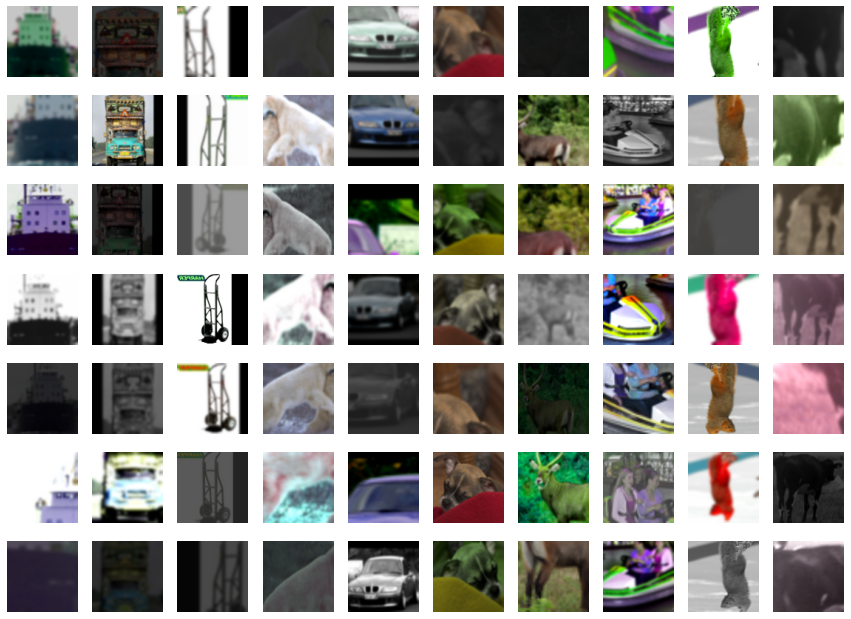

In [15]:
rndcropper = RandomResizedCrop(96, )
train_dataset.density_cropper = lambda img, salmap: rndcropper(img)
train_dataset.n_views = 7
_, idxs = visualize_samples(train_dataset, idxs)

### Experiment 1: Foveation as Blur (without crop)

In [ ]:
train_dataset = Contrastive_STL10_w_salmap(dataset_dir=dataset_dir, 
            disable_crop=True, density_cropper=None, split="unlabeled", 
            salmap_control=False, memmap=True)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


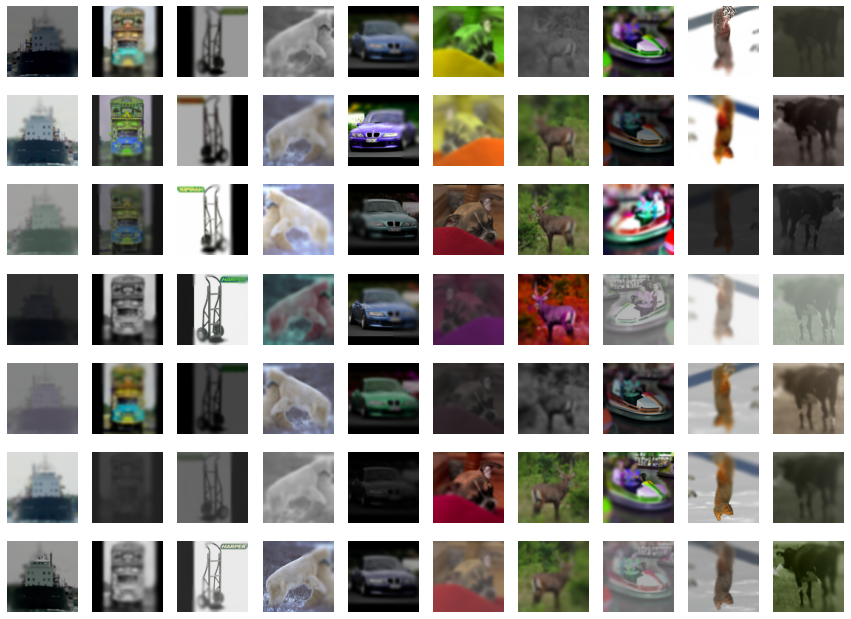

In [ ]:
train_dataset.transform = train_dataset.get_simclr_post_crop_transform(96, blur=True, foveation=True,
                  kerW_coef=0.04, fov_area_rng=[0.05, 0.8], bdr=12)
train_dataset.n_views = 7
_, idxs = visualize_samples(train_dataset, idxs)

### Experiment 3: Crop + Saliency Based Saccade 

In [ ]:
train_dataset = Contrastive_STL10_w_salmap(dataset_dir=dataset_dir,
            density_cropper=None, split="unlabeled", memmap=True) # use memory mapping to load saliency maps to save memory. 

Files already downloaded and verified


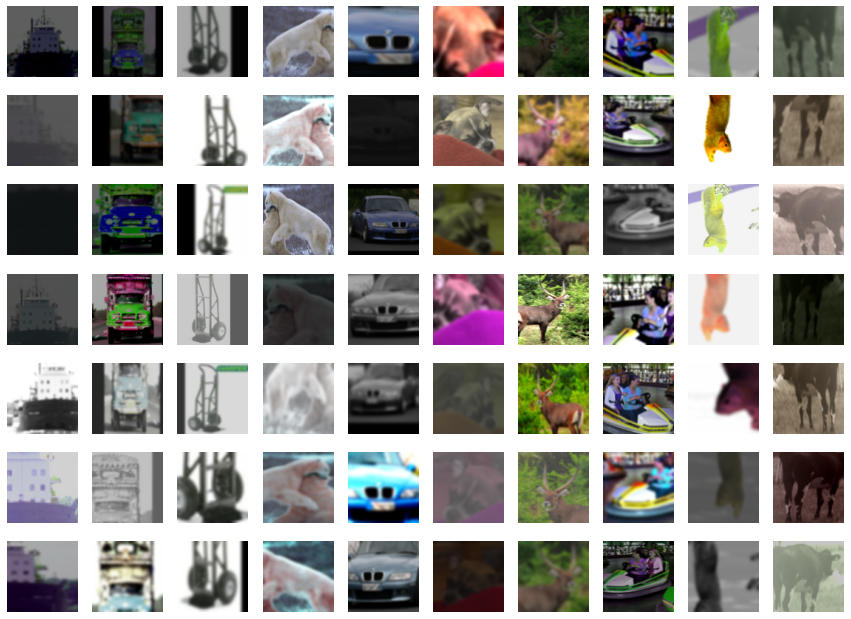

In [ ]:
crop_temperature = 1
pad_img = 0 # TODO: what is this? not in RandomResizedCrop_with_Density comments?

cropper = RandomResizedCrop_with_Density(96, \
        temperature=crop_temperature, pad_if_needed=pad_img)
cropper.pad_if_needed = False
cropper.temperature = 0.5
train_dataset.n_views = 7
train_dataset.density_cropper = cropper
_, idxs = visualize_samples(train_dataset, idxs)
# _, idxs = visualize_samples(train_dataset, ) # randomly choosing images

### Experiment 2: Cortical Magnification

In [30]:
del train_dataset

In [31]:
train_dataset = Contrastive_STL10_w_CortMagnif(dataset_dir=dataset_dir,
    transform=None, split="unlabeled", n_views=2,
    crop=False, magnif=True, sal_sample=False, memmap=True)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4216: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


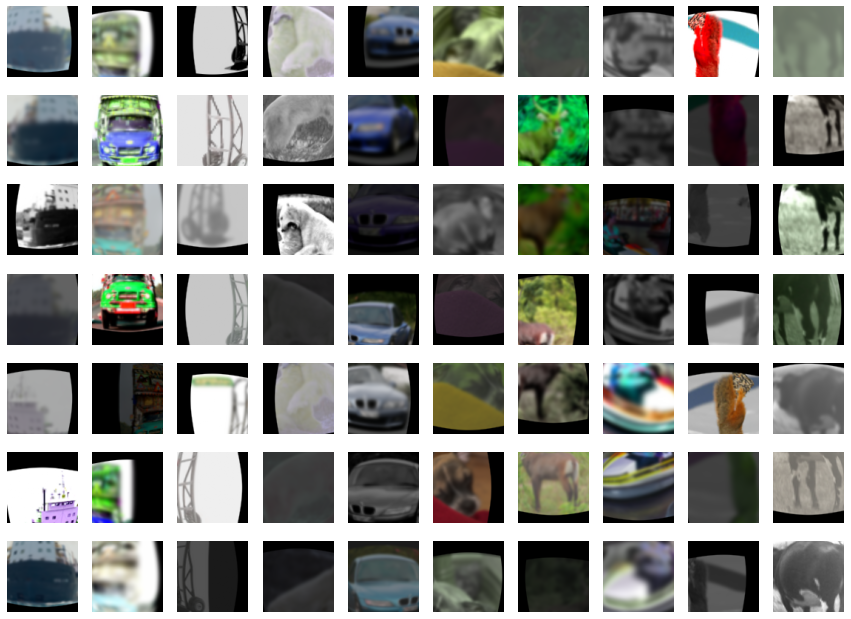

In [32]:
train_dataset.magnifier = get_RandomMagnifTfm(grid_generator="radial_quad_isotrop",
              bdr=16, fov=20, K=20, cover_ratio=0.3,
              sal_sample=False, )
train_dataset.n_views = 7
_, idxs = visualize_samples(train_dataset, idxs)

### Experiment 4: Cortical Magnification + Saliency Based Saccade

(100000, 4, 2)


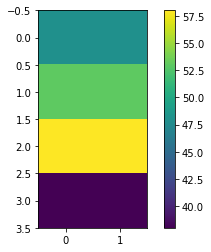

In [88]:
# fake a scanpath_arr: 
# fixation point move towards positive x & y as fixation number increases

nfix_total = 4
scanpath_arr = np.ones((len(dataset), nfix_total, 2)) # n img, n fix per img, x & y
print(scanpath_arr.shape)

scanpath_arr[:,0,:] = 96/2
scanpath_arr[:,1,:] = 96/2 + 5
scanpath_arr[:,2,:] = 96/2 + 10
scanpath_arr[:,3,:] = 96/2 - 10

plt.imshow(scanpath_arr[0,:,:])
plt.colorbar();

np.save(f"/content/Dataset/fake_scanpath.npy", scanpath_arr)

# Line 157 /content/Foveated_Saccade_SimCLR/data_aug/dataset_w_salmap.py
#         self.scanpath_arr = np.load(join(dataset_dir, "fake_scanpath.npy"),
                              #  mmap_mode="r" if memmap else None)

In [89]:
train_dataset = Contrastive_STL10_w_CortMagnif(dataset_dir=dataset_dir,
    transform=None, split="unlabeled", n_views=2,
    crop=False, magnif=True, sal_sample=False, memmap=True)

Files already downloaded and verified


In [84]:
# visualize_saliency_maps_w_imgs(train_dataset, plot_density=False, 
#                                temperature=3, bdr=16,
#                                idxs=(96659, 54019, 88327, 81148, 98469));

In [80]:
# /content/Foveated_Saccade_SimCLR/data_aug/cort_magnif_tfm.py
# randomMagnif # pY, pX = H//2, W//2 # print('always cort_magnif center')

# /content/Foveated_Saccade_SimCLR/data_aug/visualize_aug_dataset.py
# visualize_samples

# /content/Foveated_Saccade_SimCLR/data_aug/dataset_w_salmap.py
# train_dataset = Contrastive_STL10_w_CortMagnif
# Line 211: get_simclr_pre_magnif_transform # comment out color jitter, grayscale, blur

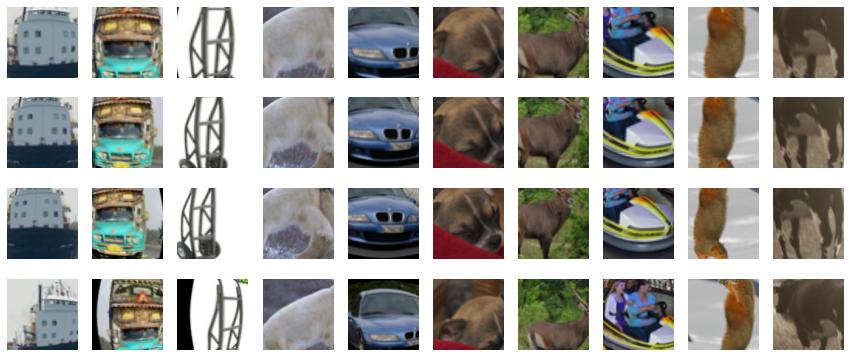

In [90]:
train_dataset.magnifier = get_RandomMagnifTfm(grid_generator="radial_quad_isotrop",
              bdr=16, fov=20, K=20, cover_ratio=0.3,
              sal_sample=True, sample_temperature=0.5,)
train_dataset.n_views = 4
_, idxs = visualize_samples(train_dataset, idxs)

(100000, 1, 96, 96)

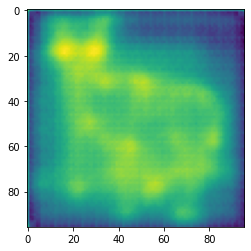

In [22]:
# salmap_bx = np.load('/content/Dataset/stl10_unlabeled_salmaps_salicon.npy')
salmap_bx = train_dataset.salmaps
plt.imshow(salmap_bx[0,0,:,:])
salmap_bx.shape